## Introduction
In this, we're using Ridge Regression to predict the Balance column from the credit dataset using multiple features like Income, Limit, Age, Education, etc.

Ridge Regression is helpful when we have many predictors and we want to avoid overfitting by shrinking the coefficients. Here’s what we’re doing:

 **Step 1: Data Study and Preparation** <br>
- We pick features from the credit dataset and standardize them.
- Our target is the Balance column.

**Step 2: Cross-Validation (5-Fold)** <br>
- We split the dataset into 5 parts.
- Each time, we train on 4 parts and test on the remaining one.
- We repeat this for many different values of lambda (the penalty strength).

**Step 3: Model Training & Testing** <br>
For each lambda:
  - We train Ridge Regression using the train set.
  - We calculate both training and testing error.<br>
Then, we pick the best lambda which gives the lowest average test error.

**Step 4: Final Model Fit**
  - Using the best lambda, we fit the model on the full dataset.
  - We adjust coefficients to their original scale.

**Step 5: Evaluation Metrics**
We compute:
 - Final MSE
 - Intercept and coefficients
 - RSS, TSS
 - Mallow's Cp
 - Adjusted R²
 - AIC and BIC

**Step 6: Visualizations**
  - Coefficient path across lambdas
  - Error vs Lambda
  - Predicted vs Actual values
  - Residual plot



## Study of 'Credit Card Balance Dataset'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import subplots
import seaborn as sns
from sklearn.model_selection import KFold


credit = pd.read_csv('Credit.csv')
print(credit.shape)
print(credit.columns)
print(credit.head(5))

print("\nIn this dataset we have some qualitative variables, so to study further we need to change then into qualitative variable first.")

# Converting qualitative variables into quantitative dataset
credit = pd.get_dummies(credit, columns=['Own', 'Student', 'Married', 'Region'], drop_first= True)
# Selecting all bool columns
bool_cols = credit.select_dtypes(include='bool').columns

# Now Converting those bool columns to int (0/1)
credit[bool_cols] = credit[bool_cols].astype(int)

print("Shape after changing some variables qualitative to quantitative ",credit.shape)
print("\n")
#Looking for description of dataset
print(credit.head(5))
credit.describe()


(400, 11)
Index(['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Own',
       'Student', 'Married', 'Region', 'Balance'],
      dtype='object')
    Income  Limit  Rating  Cards  Age  Education  Own Student Married Region  \
0   14.891   3606     283      2   34         11   No      No     Yes  South   
1  106.025   6645     483      3   82         15  Yes     Yes     Yes   West   
2  104.593   7075     514      4   71         11   No      No      No   West   
3  148.924   9504     681      3   36         11  Yes      No      No   West   
4   55.882   4897     357      2   68         16   No      No     Yes  South   

   Balance  
0      333  
1      903  
2      580  
3      964  
4      331  

In this dataset we have some qualitative variables, so to study further we need to change then into qualitative variable first.
Shape after changing some variables qualitative to quantitative  (400, 12)


    Income  Limit  Rating  Cards  Age  Education  Balance  Own_Yes  \
0   14.891

,Income,Limit,Rating,Cards,Age,Education,Balance,Own_Yes,Student_Yes,Married_Yes,Region_South,Region_West
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000,400.00000,400.000000
mean,45.218885,4735.600000,354.940000,2.957500,55.667500,13.450000,520.015000,0.517500,0.100000,0.61250,0.49750,0.255000
std,35.244273,2308.198848,154.724143,1.371275,17.249807,3.125207,459.758877,0.500319,0.300376,0.48779,0.50062,0.436407
min,10.354000,855.000000,93.000000,1.000000,23.000000,5.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000
25%,21.007250,3088.000000,247.250000,2.000000,41.750000,11.000000,68.750000,0.000000,0.000000,0.00000,0.00000,0.000000
50%,33.115500,4622.500000,344.000000,3.000000,56.000000,14.000000,459.500000,1.000000,0.000000,1.00000,0.00000,0.000000
75%,57.470750,5872.750000,437.250000,4.000000,70.000000,16.000000,863.000000,1.000000,0.000000,1.00000,1.00000,1.000000
max,186.634000,13913.000000,982.000000,9.000000,98.000000,20.000000,1999.000000,1.000000,1.000000,1.00000,1.00000,1.000000


### Correlation Matrix

Balance         1.000000
Rating          0.863625
Limit           0.861697
Income          0.463656
Student_Yes     0.259018
Cards           0.086456
Own_Yes         0.021474
Age             0.001835
Region_South   -0.003288
Married_Yes    -0.005673
Education      -0.008062
Region_West    -0.009812
Name: Balance, dtype: float64


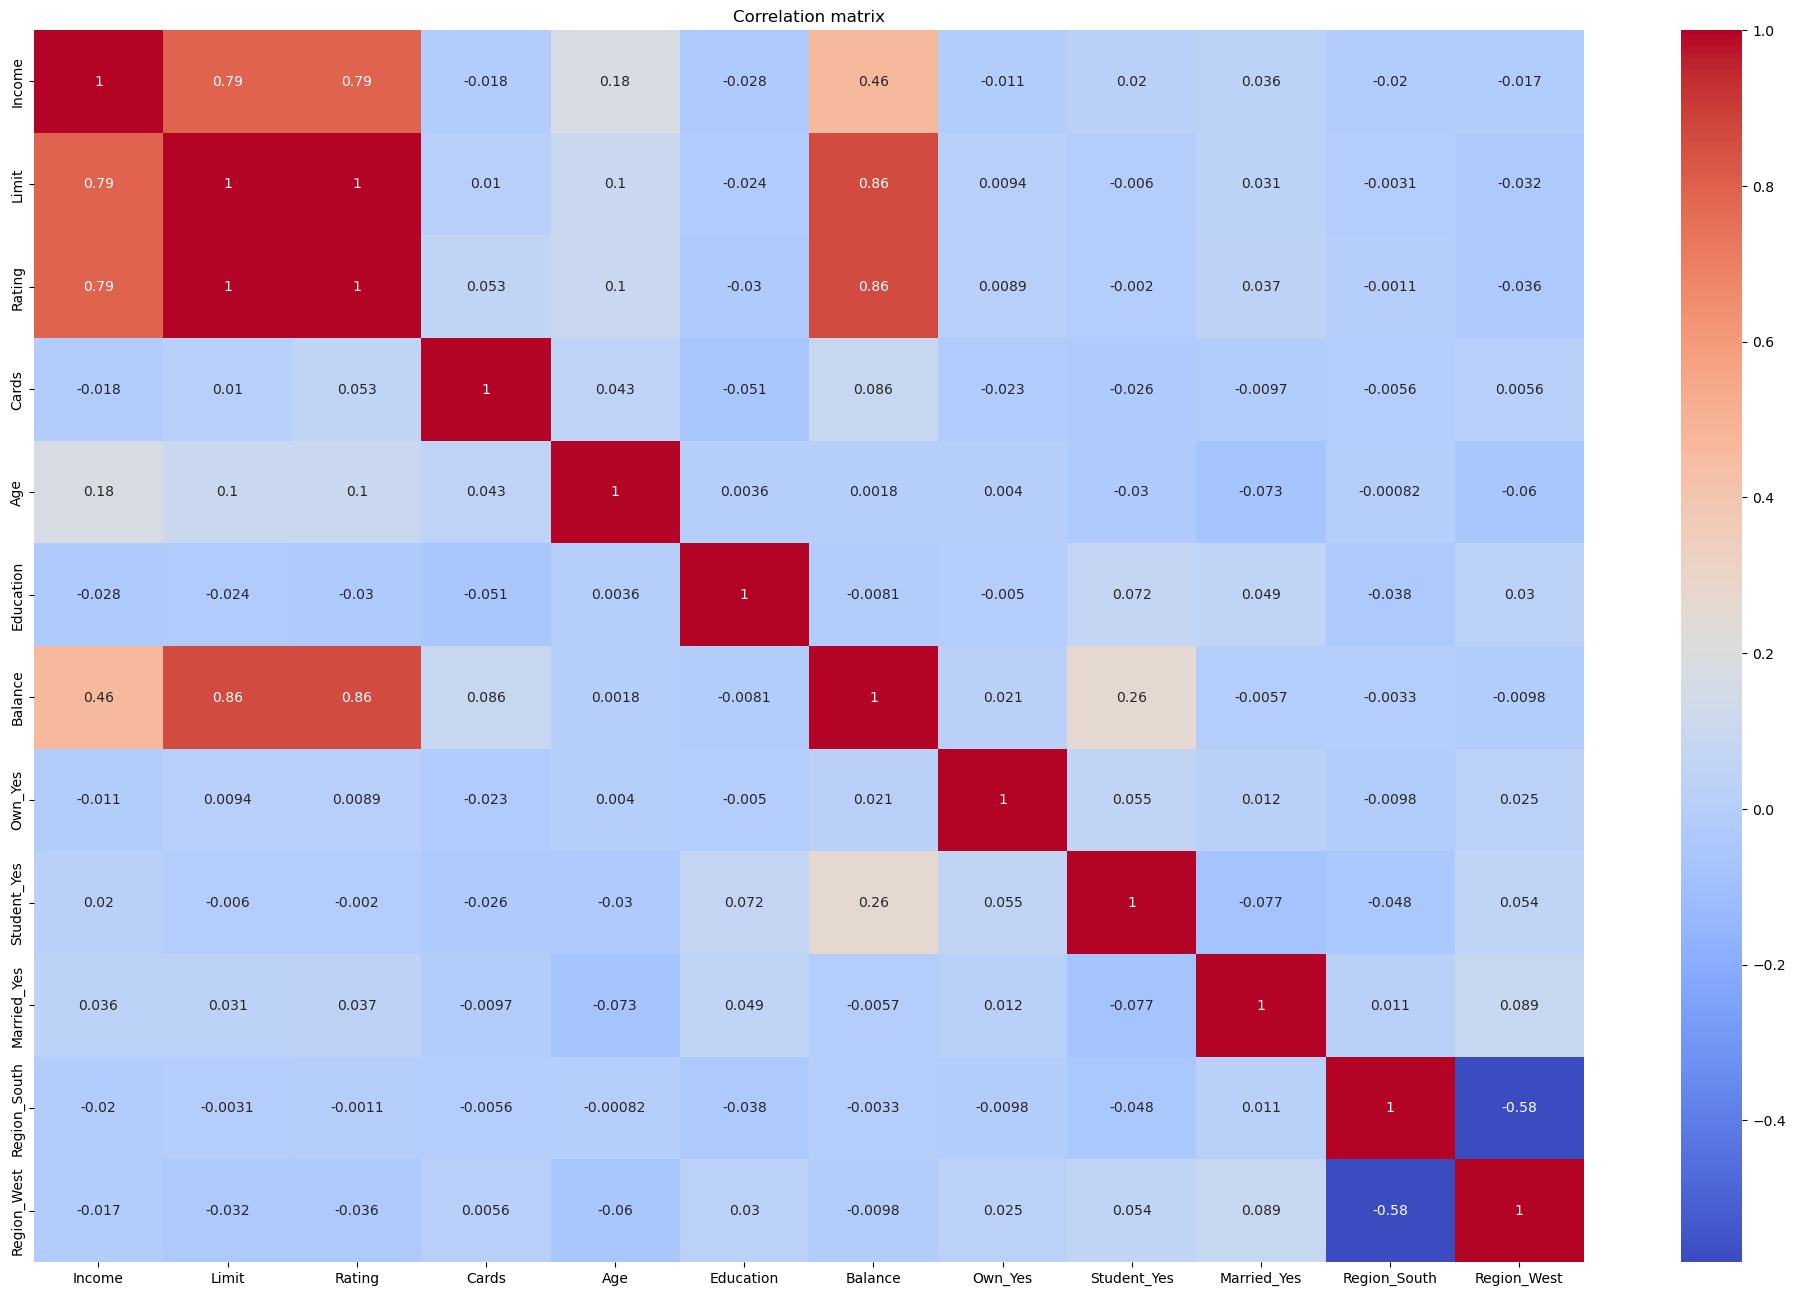

In [2]:

cor_rel = credit.corr()
k,l = subplots(figsize = (25,16))
sns.heatmap(cor_rel, annot= True, cmap='coolwarm' )
l.set_title('Correlation matrix')

cor = cor_rel['Balance'].sort_values(ascending= False)
print(cor)

- Our response variable is 'Balance' in this dataset.
- From the correlation matrix 'Limit' and 'Rating' variable strongly correlated with response variable of positive 0.86 and income correlated with response of 0.46.
- And point to be notice that correlation between 'Rating' and 'Limit' is strongly of 1 means these are not independent variable if we use these variables in multiple regression and also with 'Income' variable.


# **Algorithm of Ridge Method**

1. **Standardize Features**  
   Normalize predictors to have mean = 0 and std = 1.

2. **Define Ridge Objective**  
   Minimize:
   $$ [
   |y - X\beta\|^2 + \lambda \|\beta\|^2
   ] $$

3. **Cross-Validation for Lambda**  
   - Use k-fold CV (e.g., k = 5)
   - Train on \( k-1 \) folds, test on 1 fold
   - Repeat for all lambdas, pick λ with lowest test error

4. **Final Model Fit**  
   Train on full data with best λ  
   Unstandardize coefficients to get original-scale model

5. **Evaluate Model**  
   Compute MSE, RSS, TSS, Cp, Adjusted \( R^2 \), AIC, BIC  
   Plot: Coeff Paths, Error vs Lambda, Predicted vs Actual, Residuals


### Result:

| Metric                     | Value         |
|---------------------------|---------------|
| **Best Lambda (λ)**       | 8.5676        |
| **Mean Squared Error (MSE)** | 9868.0675    |
| **Residual Sum of Squares (RSS)** | 3,947,226.9912 |
| **Mallow’s Cp**           | 10404.8462    |
| **Akaike Information Criterion (AIC)** | 3700.8237     |
| **Bayesian Information Criterion (BIC)** | 3744.7298     |
| **Adjusted R²**           | 0.9519        |




The best lambda is : 8.5676
Final training MSE is : 9868.0675

Intercept (b0): -469.6775
Coefficient of Income: -7.0016
Coefficient of Limit: 0.1326
Coefficient of Rating: 1.8227
Coefficient of Cards: 14.6985
Coefficient of Age: -0.7362
Coefficient of Education: -0.7708
Coefficient of Balance: -8.8851
Coefficient of Own_Yes: 411.8269
Coefficient of Student_Yes: -10.9424
Coefficient of Married_Yes: 9.9864
Coefficient of Region_South: 16.6364
Total Sum of Squares (TSS) is : 84339911.9100
Residual Sum of Squares (RSS) is : 3947226.9912
CP is : 10404.8462
Adjusted R^2 is : 0.9519
AIC is : 3700.8237
BIC is : 3744.7298


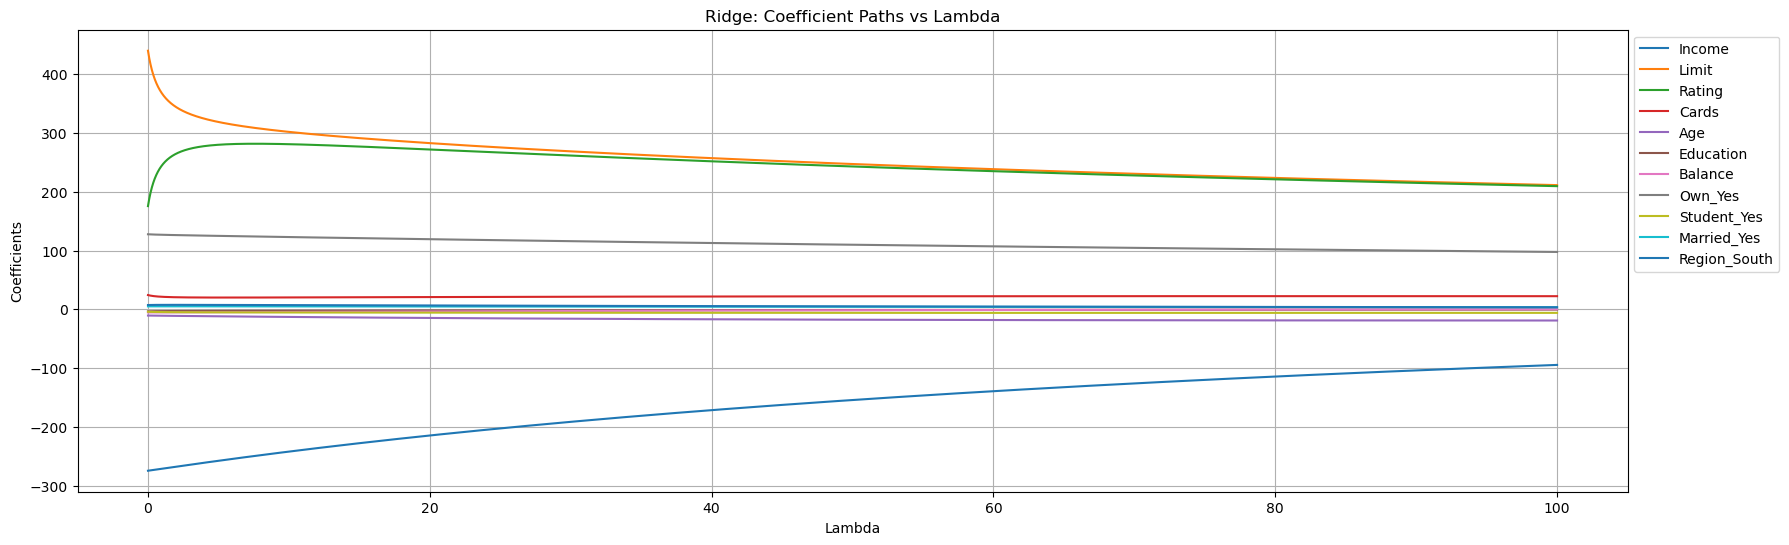

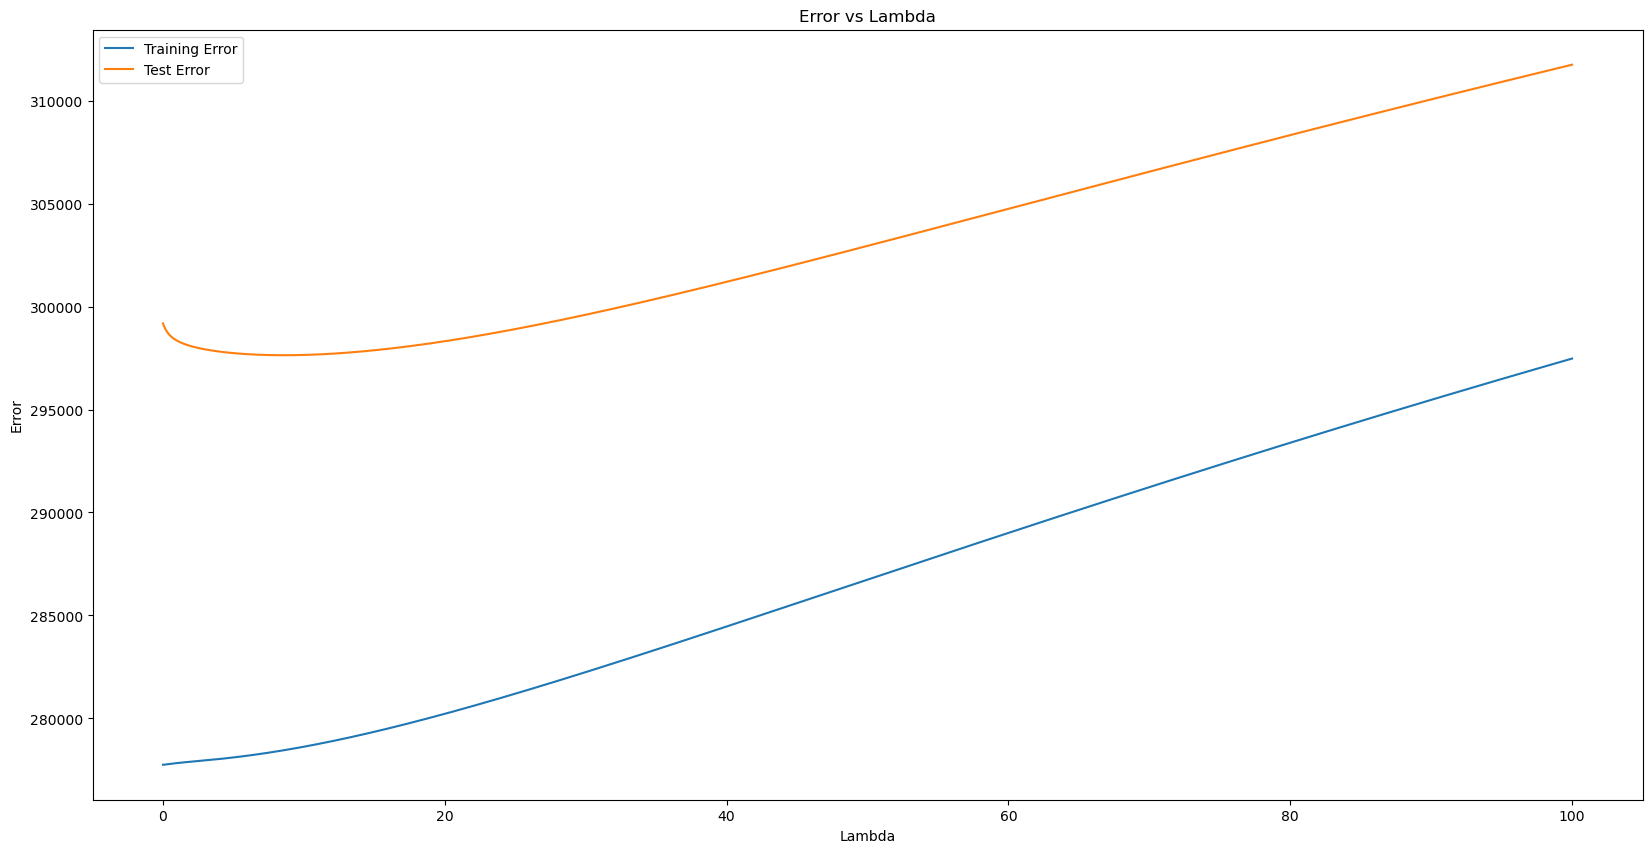

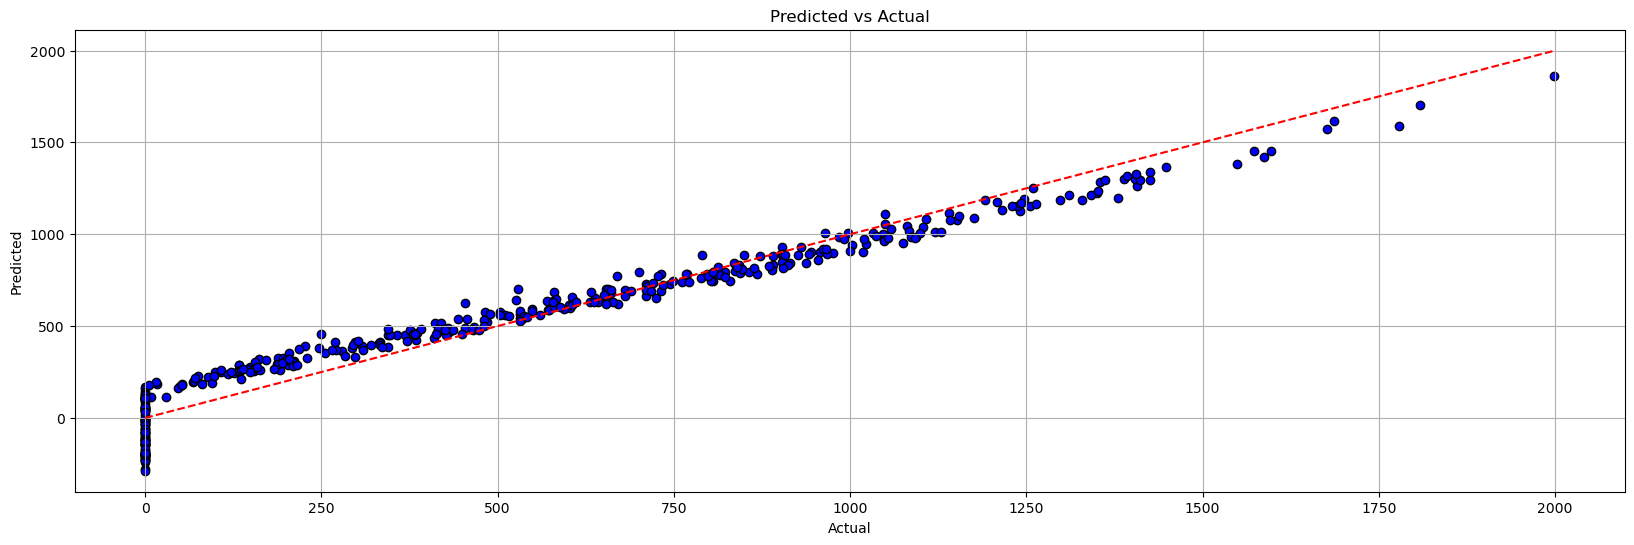

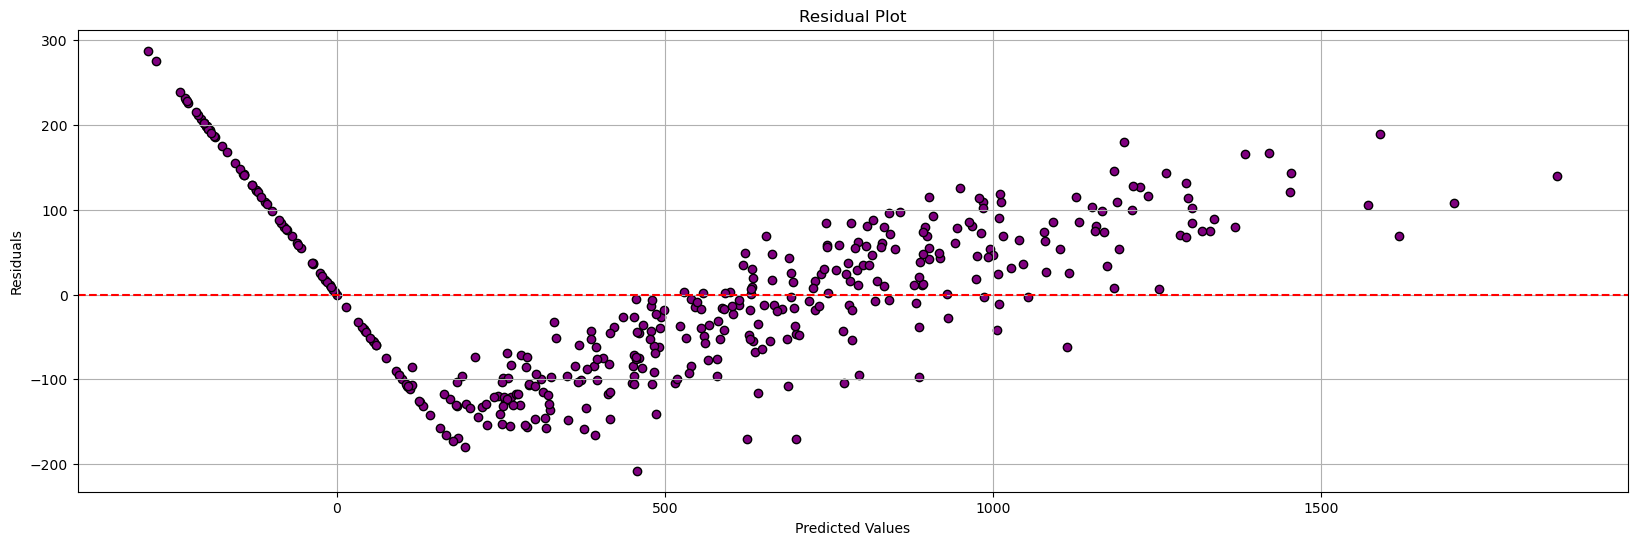

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

def train_f(x, y, lembda):
    r, c = x.shape
    identity = np.eye(c)
    return np.linalg.inv(x.T @ x + lembda * identity) @ x.T @ y

def test_f(x, y, lembda, b_train):
    r, c = x.shape
    preds = x @ b_train
    return (1/r) * np.sum((preds - y)**2)

# Assuming credit dataframe is defined before this block and contains the data
# Prepare data
y = credit['Balance'].values
x = credit[['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education',
            'Own_Yes', 'Student_Yes', 'Married_Yes', 'Region_South', 'Region_West']].values


col = credit.columns

n = len(x)
lembda = np.linspace(0, 100, 9000)

# Standardizing predictors
x_mean = np.mean(x, axis=0)
x_stdiv = np.std(x, axis=0)
x_std = (x - x_mean) / x_stdiv

#finding the k-part data
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf.get_n_splits(x_std)
kf.split(x_std)

splits = []
#x_test,x_train,y_test,y_train = 0,0,0,0
for train_index, test_index in kf.split(x_std):
    x_train , x_test = x_std[train_index] , x_std[test_index]
    y_train , y_test = y[train_index] , y[test_index]
    splits.append((x_train, y_train, x_test, y_test))

(x_train_fold1, y_train_fold1, x_test_fold1, y_test_fold1) = splits[0]
(x_train_fold2, y_train_fold2, x_test_fold2, y_test_fold2) = splits[1]
(x_train_fold3, y_train_fold3, x_test_fold3, y_test_fold3) = splits[2]
(x_train_fold4, y_train_fold4, x_test_fold4, y_test_fold4) = splits[3]
(x_train_fold5, y_train_fold5, x_test_fold5, y_test_fold5) = splits[4]

train_error = []
test_error = []

#train test on split 5 dataset
for i in lembda:
    train_error_fold = []
    test_error_fold = []

    b = (train_f(x_train_fold1, y_train_fold1, i))
    train_error_fold.append(test_f(x_train_fold1, y_train_fold1, i, b))
    test_error_fold.append(test_f(x_test_fold1, y_test_fold1, i, b))

    b = (train_f(x_train_fold2, y_train_fold2, i))
    train_error_fold.append(test_f(x_train_fold2, y_train_fold2, i, b))
    test_error_fold.append(test_f(x_test_fold2, y_test_fold2, i, b))


    b = (train_f(x_train_fold3, y_train_fold3, i))
    train_error_fold.append(test_f(x_train_fold3, y_train_fold3, i, b))
    test_error_fold.append(test_f(x_test_fold3, y_test_fold3,i, b))

    b = (train_f(x_train_fold4, y_train_fold4, i))
    train_error_fold.append(test_f(x_train_fold4, y_train_fold4, i, b))
    test_error_fold.append(test_f(x_test_fold4, y_test_fold4, i, b))

    b = (train_f(x_train_fold5, y_train_fold5, i))
    train_error_fold.append(test_f(x_train_fold5, y_train_fold5, i, b))
    test_error_fold.append(test_f(x_test_fold5, y_test_fold5, i, b))

    # calculating average of error for each lambda
    train_error.append(np.average(train_error_fold))
    test_error.append(np.average(test_error_fold))

best_index = np.argmin(test_error)
best_lambda = lembda[best_index]
print(f"The best lambda is : {best_lambda:.4f}")

# Train on full dataset with best lambda
b_ridge = train_f(x_std, y, best_lambda)  # coefficients without intercept

# Un-standardize coefficients
b_aft_std = b_ridge / x_stdiv
b0 = np.mean(y) - np.sum(b_aft_std * x_mean)

# b_full includes intercept
b_full = np.insert(b_aft_std, 0, b0)

# Compute MSE on full dataset - must add intercept column to x_std
x_full = np.c_[np.ones(n), x]

y_pred_full = x_full @ b_full
y_pred_ridge = y_pred_full

final_mse = np.mean((y - y_pred_full)**2)
print(f'Final training MSE is : {final_mse:.4f}\n')



# Print coefficients
print(f"Intercept (b0): {b0:.4f}")
for i in range(len(b_aft_std)):
    print(f"Coefficient of {col[i]}: {b_aft_std[i]:.4f}")

# Calculate RSS and TSS using full standardized data with intercept
RSS = np.sum((y - y_pred_full)**2)
TSS = np.sum((y - np.mean(y))**2)
print(f'Total Sum of Squares (TSS) is : {TSS:.4f}')
print(f'Residual Sum of Squares (RSS) is : {RSS:.4f}')

# Mallow's Cp
d = len(b_aft_std)  # number of predictors without intercept

# OLS fit for sigma^2 estimation
b_ols = np.linalg.inv(x_full.T @ x_full) @ (x_full.T @ y)
residual_ols = y - x_full @ b_ols
rss_full = np.sum(residual_ols**2)
sigma_sq = rss_full / (n - d - 1)

Cp = (1 / n) * (RSS + 2 * d * sigma_sq)
print(f'CP is : {Cp:.4f}')

# Adjusted R^2
adj_R_sqr = 1 - ((RSS * (n - 1)) / (TSS * (n - d - 1)))
print(f'Adjusted R^2 is : {adj_R_sqr:.4f}')

# AIC and BIC
aic = n * np.log(RSS / n) + 2 * d
bic = n * np.log(RSS / n) + d * np.log(n)
print(f'AIC is : {aic:.4f}')
print(f'BIC is : {bic:.4f}')

# Coefficients paths across lambdas plotting
coefs = []
for l in lembda:
    b = train_f(x_std, y, l)
    coefs.append(b)
coefs = np.array(coefs)

plt.figure(figsize=(20,6))
for i in range(coefs.shape[1]):
    plt.plot(lembda, coefs[:, i], label=col[i])
plt.xlabel("Lambda")
plt.ylabel("Coefficients")
plt.title("Ridge: Coefficient Paths vs Lambda")
plt.legend(loc='best', bbox_to_anchor=(1,1))
plt.grid(True)
plt.show()

# Plot lambda vs error
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(lembda, train_error, label='Training Error')
ax.plot(lembda, test_error, label='Test Error')
ax.set_xlabel('Lambda')
ax.set_ylabel('Error')
ax.set_title('Error vs Lambda')
ax.legend()
plt.show()

# Predicted vs Actual plot with best lambda
y_pred = b0 + x @ b_aft_std  # original scale predictors
residuals = y - y_pred

plt.figure(figsize=(20,6))
plt.scatter(y, y_pred, color='blue', edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.show()

# Residual plot
plt.figure(figsize=(20,6))
plt.scatter(y_pred, residuals, color='purple', edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)
plt.show()


## Ridge Regression with Interaction Terms (Non-Linearity)

We perform Ridge Regression using 5-fold cross-validation to select the optimal regularization parameter (`lambda`) that minimizes test error. To capture **non-linear relationships** and improve model performance, we included interaction terms between highly correlated predictors (`Income * Limit`, `Limit * Rating`, `Rating * Income`).

These interaction terms introduce non-linearity and help the model generalize better, as seen in the reduced Cp, AIC, BIC and increased Adjusted R².

### Key Steps:

- Standardize all predictors to ensure uniform regularization.
- Generate 3 non-linear interaction terms based on observed correlations:
  - `Income * Limit`
  - `Limit * Rating`
  - `Rating * Income`
- Perform 5-fold cross-validation to evaluate error across a range of lambda values.
- Select best lambda using average test error.
- Retrain model on full dataset using best lambda.
- De-standardize coefficients for interpretation.
- Compute model evaluation metrics:
  - **Final MSE**
  - **Cp (Mallow’s)**
  - **Adjusted R²**
  - **AIC and BIC**
- Visualize:
  - Coefficient shrinkage paths across lambdas
  - Lambda vs error
  - Predicted vs actual
  - Residuals plot

### Result Summary:

- Interaction features improved model fit and generalization.
- Final model achieves:
  -  Lower **Cp**, **AIC**, **BIC**
  -  Higher **Adjusted R²**
  -  Better error distribution and predictive alignment

  ### Result:

| Metric                     | Value         |
|---------------------------|---------------|
| **Best Lambda (λ)**       | 16.6130       |
| **Mean Squared Error (MSE)** | 7396.5638    |
| **Residual Sum of Squares (RSS)** | 2,958,625.5188 |
| **Mallow’s Cp**           | 7780.0033     |
| **Akaike Information Criterion (AIC)** | 3591.5083     |
| **Bayesian Information Criterion (BIC)** | 3647.3888     |
| **Adjusted R²**           | 0.9636        |



The best lambda is : 16.6130
Final training MSE is : 7396.5638

Intercept (b0): -320.8078
Coefficient of Income: -5.5542
Coefficient of Limit: 0.0946
Coefficient of Rating: 1.3052
Coefficient of Cards: 13.8580
Coefficient of Age: -0.8398
Coefficient of Education: -0.9859
Coefficient of Own_Yes: -6.6511
Coefficient of Student_Yes: 408.4372
Coefficient of Married_Yes: -10.9445
Coefficient of Region_South: 11.3372
Coefficient of Region_West: 14.9823
Coefficient of Income*Limit: -0.0001
Coefficient of Limit*Rating: 0.0001
Coefficient of Rating*Income: -0.0024
Total Sum of Squares (TSS) is : 84339911.9100
Residual Sum of Squares (RSS) is : 2958625.5188
CP is : 7780.0033
Adjusted R^2 is : 0.9636
AIC is : 3591.5083
BIC is : 3647.3888


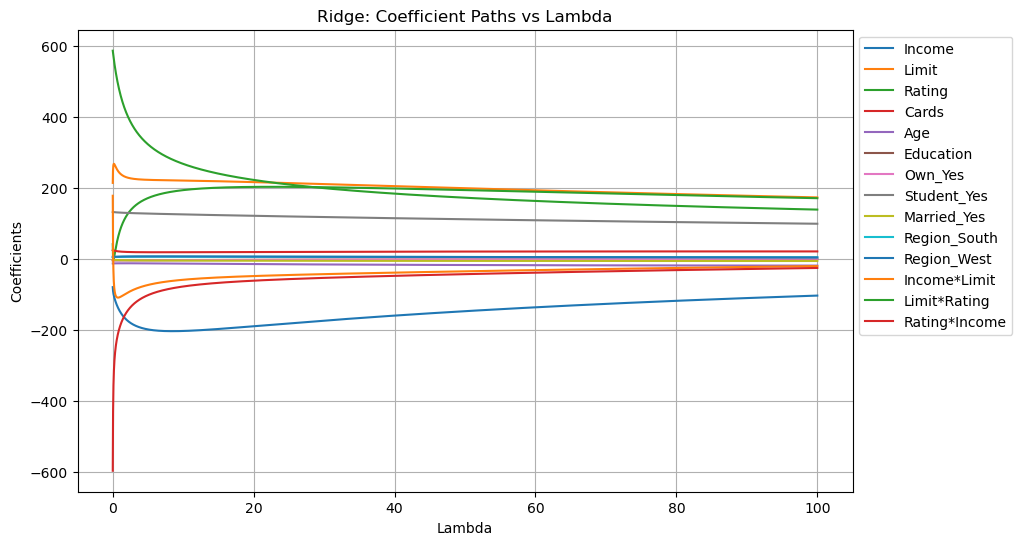

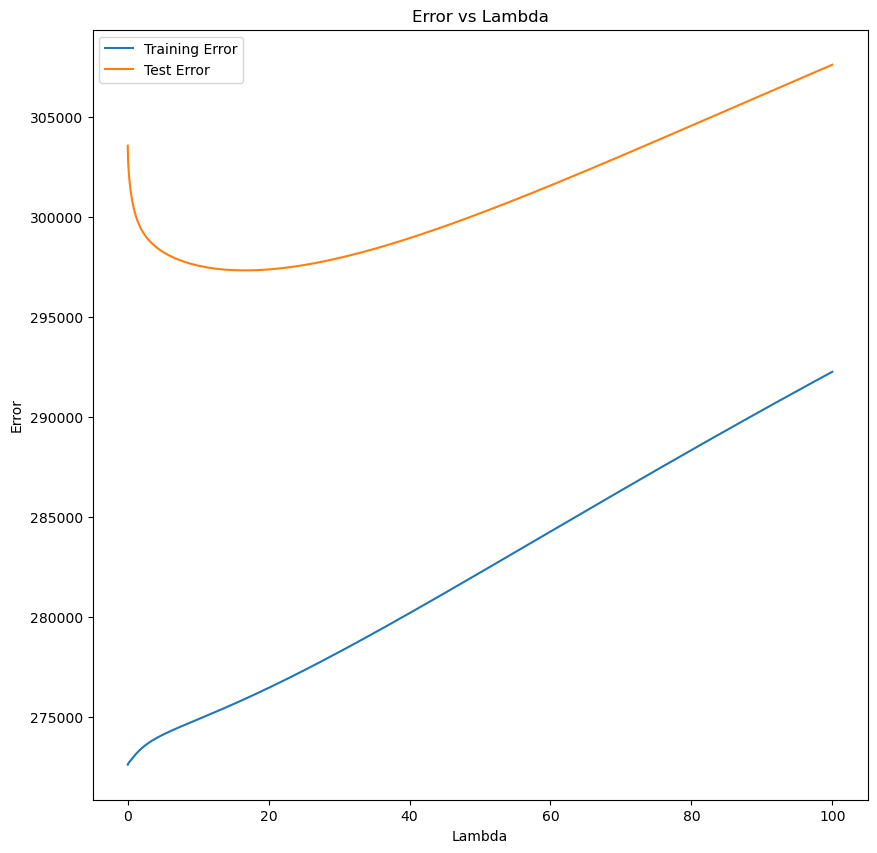

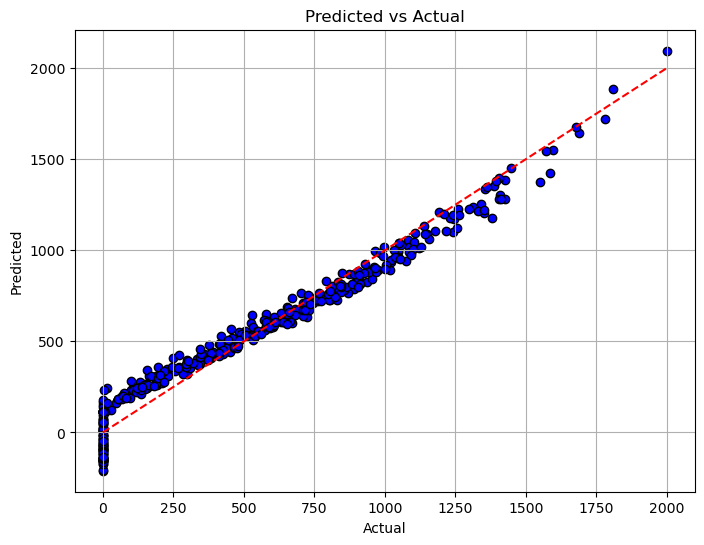

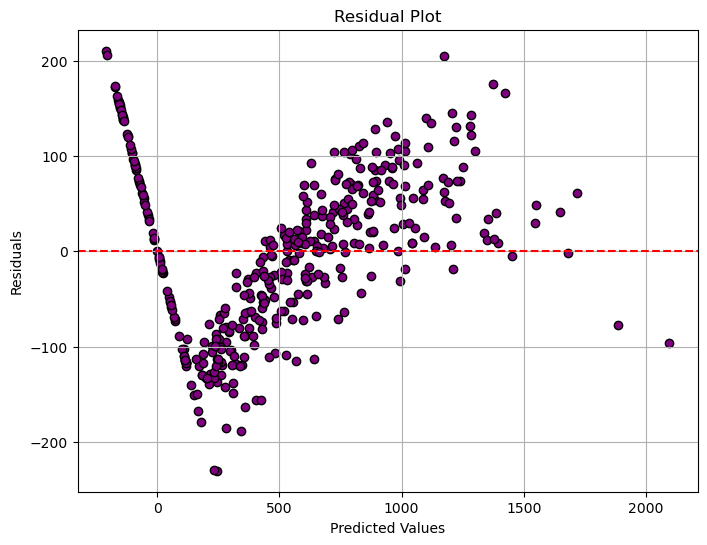

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

def train_f(x, y, lembda):
    r, c = x.shape
    identity = np.eye(c)
    return np.linalg.inv(x.T @ x + lembda * identity) @ x.T @ y

def test_f(x, y, lembda, b_train):
    r, c = x.shape
    preds = x @ b_train
    return (1/r) * np.sum((preds - y)**2)

# Prepare data
y = credit['Balance'].values
x = credit[['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education',
            'Own_Yes', 'Student_Yes', 'Married_Yes', 'Region_South', 'Region_West']].values

# Create interaction terms BEFORE standardization
x1 = (credit['Income'] * credit['Limit']).values.reshape(-1,1)
x2 = (credit['Limit'] * credit['Rating']).values.reshape(-1,1)
x3 = (credit['Rating'] * credit['Income']).values.reshape(-1,1)

col = ['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education',
       'Own_Yes', 'Student_Yes', 'Married_Yes', 'Region_South', 'Region_West',
       'Income*Limit', 'Limit*Rating', 'Rating*Income']


# Combine all features
x = np.hstack((x, x1, x2, x3))


# Standardizing predictors
x_mean = np.mean(x, axis=0)
x_stdiv = np.std(x, axis=0)
x_std = (x - x_mean) / x_stdiv

#finding the k-part data
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf.get_n_splits(x_std)
kf.split(x_std)

splits = []
#x_test,x_train,y_test,y_train = 0,0,0,0
for train_index, test_index in kf.split(x_std):
    x_train , x_test = x_std[train_index] , x_std[test_index]
    y_train , y_test = y[train_index] , y[test_index]
    splits.append((x_train, y_train, x_test, y_test))

(x_train_fold1, y_train_fold1, x_test_fold1, y_test_fold1) = splits[0]
(x_train_fold2, y_train_fold2, x_test_fold2, y_test_fold2) = splits[1]
(x_train_fold3, y_train_fold3, x_test_fold3, y_test_fold3) = splits[2]
(x_train_fold4, y_train_fold4, x_test_fold4, y_test_fold4) = splits[3]
(x_train_fold5, y_train_fold5, x_test_fold5, y_test_fold5) = splits[4]

train_error = []
test_error = []

#train test on split 5 dataset
for i in lembda:
    train_error_fold = []
    test_error_fold = []

    b = (train_f(x_train_fold1, y_train_fold1, i))
    train_error_fold.append(test_f(x_train_fold1, y_train_fold1, i, b))
    test_error_fold.append(test_f(x_test_fold1, y_test_fold1, i, b))

    b = (train_f(x_train_fold2, y_train_fold2, i))
    train_error_fold.append(test_f(x_train_fold2, y_train_fold2, i, b))
    test_error_fold.append(test_f(x_test_fold2, y_test_fold2, i, b))


    b = (train_f(x_train_fold3, y_train_fold3, i))
    train_error_fold.append(test_f(x_train_fold3, y_train_fold3, i, b))
    test_error_fold.append(test_f(x_test_fold3, y_test_fold3,i, b))

    b = (train_f(x_train_fold4, y_train_fold4, i))
    train_error_fold.append(test_f(x_train_fold4, y_train_fold4, i, b))
    test_error_fold.append(test_f(x_test_fold4, y_test_fold4, i, b))

    b = (train_f(x_train_fold5, y_train_fold5, i))
    train_error_fold.append(test_f(x_train_fold5, y_train_fold5, i, b))
    test_error_fold.append(test_f(x_test_fold5, y_test_fold5, i, b))

    # calculating average of error for each lambda
    train_error.append(np.average(train_error_fold))
    test_error.append(np.average(test_error_fold))

best_index = np.argmin(test_error)
best_lambda = lembda[best_index]
print(f"The best lambda is : {best_lambda:.4f}")

# Train on full dataset with best lambda
b_ridge = train_f(x_std, y, best_lambda)  # coefficients without intercept

# Un-standardize coefficients
b_aft_std = b_ridge / x_stdiv
b0 = np.mean(y) - np.sum(b_aft_std * x_mean)

# b_full includes intercept
b_full = np.insert(b_aft_std, 0, b0)

# Compute MSE on full dataset - must add intercept column to x_std
x_full = np.c_[np.ones(n), x]

y_pred_full = x_full @ b_full

final_mse = np.mean((y - y_pred_full)**2)
print(f'Final training MSE is : {final_mse:.4f}\n')

# Print coefficients
print(f"Intercept (b0): {b0:.4f}")
for i in range(len(b_aft_std)):
    print(f"Coefficient of {col[i]}: {b_aft_std[i]:.4f}")

# Calculate RSS and TSS using full standardized data with intercept
RSS = np.sum((y - y_pred_full)**2)
TSS = np.sum((y - np.mean(y))**2)
print(f'Total Sum of Squares (TSS) is : {TSS:.4f}')
print(f'Residual Sum of Squares (RSS) is : {RSS:.4f}')

# Mallow's Cp
d = len(b_aft_std)  # number of predictors without intercept

# OLS fit for sigma^2 estimation
b_ols = np.linalg.inv(x_full.T @ x_full) @ (x_full.T @ y)
residual_ols = y - x_full @ b_ols
rss_full = np.sum(residual_ols**2)
sigma_sq = rss_full / (n - d - 1)

Cp = (1 / n) * (RSS + 2 * d * sigma_sq)
print(f'CP is : {Cp:.4f}')

# Adjusted R^2
adj_R_sqr = 1 - ((RSS * (n - 1)) / (TSS * (n - d - 1)))
print(f'Adjusted R^2 is : {adj_R_sqr:.4f}')

# AIC and BIC
aic = n * np.log(RSS / n) + 2 * d
bic = n * np.log(RSS / n) + d * np.log(n)
print(f'AIC is : {aic:.4f}')
print(f'BIC is : {bic:.4f}')

# Coefficients paths across lambdas plotting
coefs = []
for l in lembda:
    b = train_f(x_std, y, l)
    coefs.append(b)
coefs = np.array(coefs)

plt.figure(figsize=(10,6))
for i in range(coefs.shape[1]):
    plt.plot(lembda, coefs[:, i], label=col[i])
plt.xlabel("Lambda")
plt.ylabel("Coefficients")
plt.title("Ridge: Coefficient Paths vs Lambda")
plt.legend(loc='best', bbox_to_anchor=(1,1))
plt.grid(True)
plt.show()

# Plot lambda vs error
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(lembda, train_error, label='Training Error')
ax.plot(lembda, test_error, label='Test Error')
ax.set_xlabel('Lambda')
ax.set_ylabel('Error')
ax.set_title('Error vs Lambda')
ax.legend()
plt.show()

# Predicted vs Actual plot with best lambda
y_pred = b0 + x @ b_aft_std  # original scale predictors
residuals = y - y_pred

plt.figure(figsize=(8,6))
plt.scatter(y, y_pred, color='blue', edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.show()

# Residual plot
plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, color='purple', edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)
plt.show()


##  Comparison: Ridge Regression vs Ridge with Interaction Terms

| Metric                         | Ridge Regression          | Ridge Regression + Interaction Terms |
|-------------------------------|---------------------------|---------------------------------------|
| **Best Lambda**               | 8.5676                    | 16.6130                               |
| **Final Training MSE**        | 9868.0675                 | 7396.5638                             |
| **Residual Sum of Squares**   | 3,947,226.9912            | 2,958,625.5188                        |
| **Total Sum of Squares (TSS)**| 84,339,911.9100           | 84,339,911.9100                       |
| **Mallow’s Cp**               | 10404.8462                | 7780.0033                             |
| **Adjusted R²**               | 0.9519                    | 0.9636                                |
| **AIC**                       | 3700.8237                 | 3591.5083                             |
| **BIC**                       | 3744.7298                 | 3647.3888                             |
| **# of Features Used**        | 12                        | 15                                    |
| **Included Non-linearity**    |  No                     | Yes (Interaction Terms)           |

###  Conclusion:
Adding interaction terms significantly:
-  Reduced **MSE**, **RSS**, **Cp**, **AIC**, and **BIC**
-  Improved **Adjusted R²**
-  Captured **non-linear relations** via new features (`Income*Limit`, `Limit*Rating`, `Rating*Income`)

This clearly shows how modeling non-linearities boosts predictive power in Ridge Regression!


# **LASSO (Least Absolute Srinkage and Selection Operator)**

### Concept

Lasso (Least Absolute Shrinkage and Selection Operator) is a linear regression method that performs:
- **Regularization** (to prevent overfitting),
- **Variable selection** (by shrinking some coefficients exactly to zero).

---

### Objective Function

Lasso minimizes the following loss:

$$ [
{Loss} = \frac{1}{n} \sum_{i=1}^n (y_i - \mathbf{x}_i^T \boldsymbol{\beta})^2 + \lambda \sum_{j=1}^p |\beta_j|
] $$

- First term = Mean Squared Error  
- Second term = L1 penalty (absolute value of coefficients)

---

### Why L1 Penalty (Lasso) is Special

- Encourages **sparse solutions** (many coefficients = 0)
- Unlike Ridge (L2), Lasso **performs feature selection**
- Useful in **high-dimensional settings** or **interpretability-focused models**

---

### Algorithm: Coordinate Descent for Lasso

1. **Initialize** all coefficients β = 0  
2. **Iteratively update** one coefficient at a time:
   - Compute partial residuals
   - Apply **soft-thresholding**:

$$ [
beta_j = \frac{1}{n} \cdot \frac{S\left(\sum x_{ij}(r_i + \beta_j x_{ij}), lambda\right)}{\frac{1}{n} \sum x_{ij}^2}
] $$

Where:
$$ [
S(\rho, \lambda) =
\begin{cases}
\rho - \lambda & \rho > \lambda \\
0 & |\rho| \leq \lambda \\
\rho + \lambda & \rho < -\lambda
\end{cases}
] $$

3. Repeat until convergence (small change in β)

---

### Model Evaluation Metrics

After training with optimal λ (via cross-validation):

- **RSS**: Residual Sum of Squares  
- **TSS**: Total Sum of Squares  
- **MSE / RMSE**: Prediction error  
- **R² / Adjusted R²**: Model fit  
- **Mallow’s Cp, AIC, BIC**: Model selection criteria

---

### Tuning λ (Regularization Parameter)

- Use **k-fold Cross-Validation**
- Try multiple λ values (log-spaced)
- Pick λ that minimizes average CV error

---

### Geometric Interpretation

- Lasso constraint region is a **diamond (L1 ball)**  
- When contours of MSE touch the **corner** of this diamond, some coefficients become **exactly zero**
- This leads to **sparse models**

---

### Final Notes

- Lasso helps interpretability by **automatically selecting features**  
- Sensitive to correlated predictors (only one may be selected)  

### Result:

| Metric                     | Value         |
|---------------------------|---------------|
| **Best Lambda (λ)**       | 0.0100        |
| **Mean Squared Error (MSE)** | 9466.85     |
| **Residual Sum of Squares (RSS)** | 3,786,740.51 |
| **Mallow’s Cp**           | 10003.63      |
| **Akaike Information Criterion (AIC)** | 10003.63     |
| **Bayesian Information Criterion (BIC)** | 11074.90     |
| **Adjusted R²**           | 0.9538        |



Best Lambda Value: 0.0100

Lasso Coefficients:
Intercept (β₀): -478.8119
Coefficient for Income: -7.8019
Coefficient for Limit: 0.1919
Coefficient for Rating: 1.1210
Coefficient for Cards: 17.7937
Coefficient for Age: -0.6134
Coefficient for Education: -1.0996
Coefficient for Own_Yes: -10.6296
Coefficient for Student_Yes: 425.7599
Coefficient for Married_Yes: -8.4749
Coefficient for Region_South: 10.0553
Coefficient for Region_West: 16.7185

Lasso Results:
RSS: 3786740.51
Estimated Variance σ²: 9759.64
Mallow's Cp: 10003.63
AIC: 10003.63
BIC: 11074.90
MSE: 9466.85
RMSE: 97.30
R²: 0.9551
Adjusted R²: 0.9538


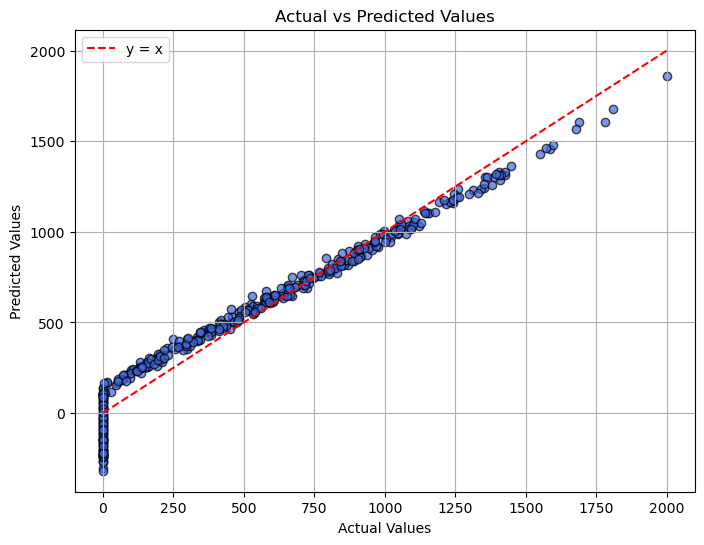

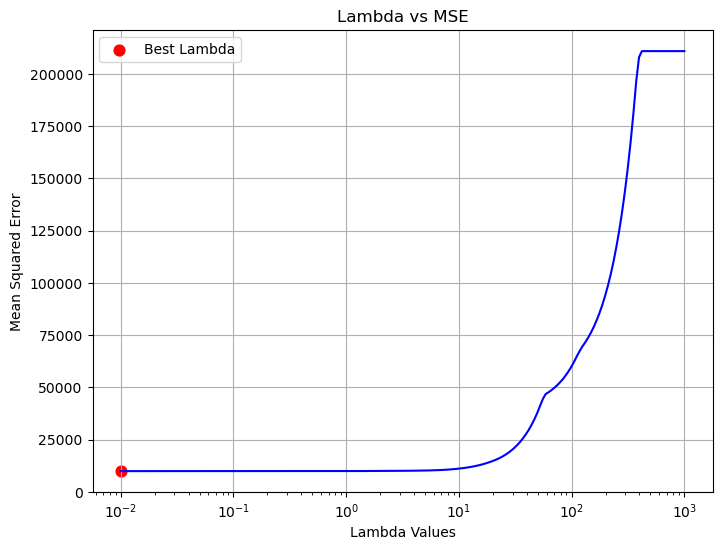

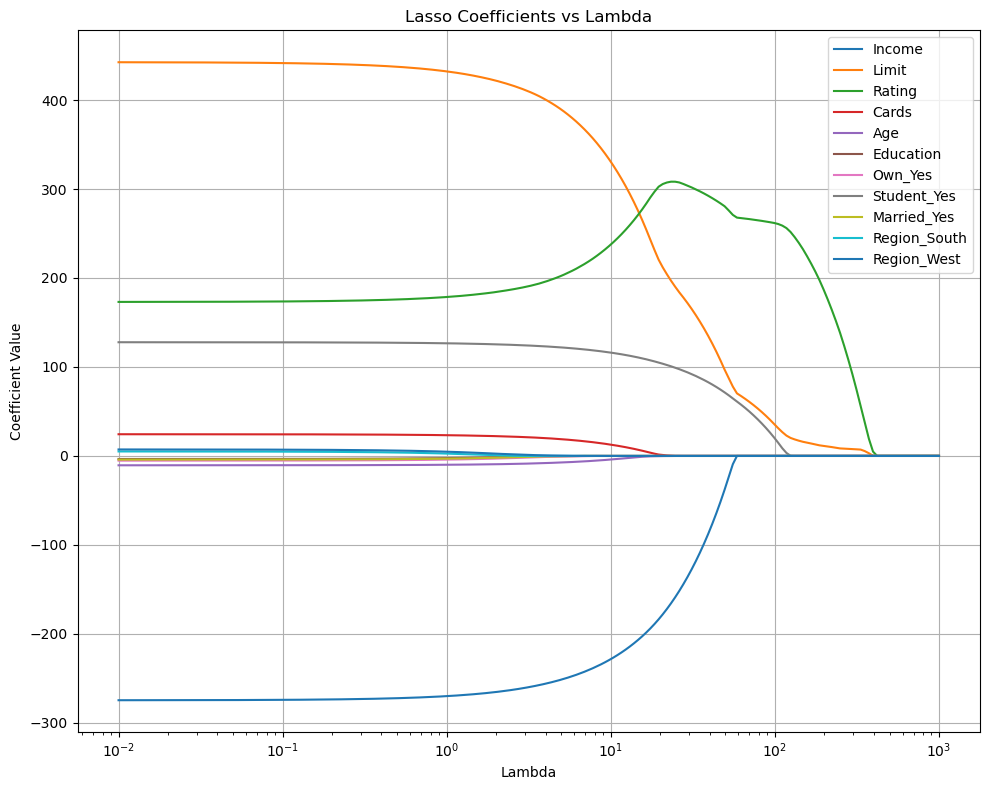

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# Soft Thresholding Function
def soft_threshold(rho, lam):
    if rho < -lam:
        return rho + lam
    elif rho > lam:
        return rho - lam
    else:
        return 0.0

# Lasso via Coordinate Descent
def lasso_coordinate_descent(X, y, lam, tol=1e-4, max_iter=1000):
    n, p = X.shape
    beta = np.zeros(p)

    for _ in range(max_iter):
        beta_old = beta.copy()
        for j in range(p):
            X_j = X[:, j]
            y_pred = X @ beta
            residual = y - y_pred + beta[j] * X_j
            rho_j = np.dot(X_j, residual)
            beta[j] = soft_threshold(rho_j / n, lam) / (np.dot(X_j, X_j) / n)
        if np.sum(np.abs(beta - beta_old)) < tol:
            break
    return beta

# Adjusted R² Function
def adjusted_r2_score(y_true, y_pred, p):
    n = len(y_true)
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Load data
y = credit['Balance'].values
x = credit[['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education',
            'Own_Yes', 'Student_Yes', 'Married_Yes', 'Region_South', 'Region_West']].values
col_names = credit[['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education',
                    'Own_Yes', 'Student_Yes', 'Married_Yes', 'Region_South', 'Region_West']].columns

# Standardize predictors
x_mean = np.mean(x, axis=0)
x_std = np.std(x, axis=0)
x_standardized = (x - x_mean) / x_std

# Center y
y_mean = np.mean(y)
y_centre = y - y_mean

# Cross-validation settings
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)
lambda_values = np.logspace(-2, 3, 200)
avg_cv_errors = []
coefs = []

# Cross-validation loop
for lam in lambda_values:
    cv_errors = []
    coef_path = []

    for train_idx, val_idx in kf.split(x_standardized):
        X_train, X_val = x_standardized[train_idx], x_standardized[val_idx]
        y_train_cen = y_centre[train_idx]
        y_val = y[val_idx]

        beta_lasso = lasso_coordinate_descent(X_train, y_train_cen, lam)
        coef_path.append(beta_lasso)

        y_pred = X_val @ beta_lasso
        mse = mean_squared_error(y_val, y_pred + y_mean)
        cv_errors.append(mse)

    avg_cv_errors.append(np.mean(cv_errors))
    coefs.append(np.mean(coef_path, axis=0))

coefs = np.array(coefs)
best_lambda = lambda_values[np.argmin(avg_cv_errors)]
print(f"Best Lambda Value: {best_lambda:.4f}")

# Final model training
final_beta = lasso_coordinate_descent(x_standardized, y_centre, best_lambda)
final_beta_lasso = final_beta / x_std
beta_0 = y_mean - np.dot(final_beta_lasso, x_mean)
beta_full = np.insert(final_beta_lasso, 0, beta_0)

# Predictions on original scale
X_full = np.column_stack((np.ones(x.shape[0]), x))
y_pred_lasso = X_full @ beta_full

# Metrics
rss = np.sum((y - y_pred_lasso) ** 2)
tss = np.sum((y - y_mean) ** 2)
n = len(y)
p = x.shape[1]
sigma_squared = rss / (n - p - 1)

cp = (rss + 2 * p * sigma_squared) / n
aic = cp
bic = (rss + np.log(n) * p * sigma_squared) / n
mse = mean_squared_error(y, y_pred_lasso)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred_lasso)
adj_r2 = adjusted_r2_score(y, y_pred_lasso, p)

print("\nLasso Coefficients:")
for i, coef in enumerate(beta_full):
    if i == 0:
        print(f"Intercept (β₀): {coef:.4f}")
    else:
        print(f"Coefficient for {col_names[i-1]}: {coef:.4f}")

print("\nLasso Results:")
print(f"RSS: {rss:.2f}")
print(f"Estimated Variance σ²: {sigma_squared:.2f}")
print(f"Mallow's Cp: {cp:.2f}")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"Adjusted R²: {adj_r2:.4f}")

# Plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred_lasso, color='royalblue', edgecolor='k', alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='y = x')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

# Plot: Lambda vs MSE
plt.figure(figsize=(8, 6))
plt.plot(lambda_values, avg_cv_errors, color='blue')
plt.xscale('log')
plt.xlabel("Lambda Values")
plt.ylabel("Mean Squared Error")
plt.title("Lambda vs MSE")
plt.scatter(best_lambda, avg_cv_errors[np.argmin(avg_cv_errors)], color='red', s=60, label="Best Lambda")
plt.legend()
plt.grid(True)
plt.show()

# Plot: Coefficients vs Lambda
plt.figure(figsize=(10, 8))
for i in range(coefs.shape[1]):
    plt.plot(lambda_values, coefs[:, i], label=col_names[i])
plt.xscale('log')
plt.xlabel("Lambda")
plt.ylabel("Coefficient Value")
plt.title("Lasso Coefficients vs Lambda")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **Comparision of Ridge and LASSO**

## Ridge vs Lasso Regression Comparison

| Metric                     | Ridge Regression            | Lasso Regression             |
|----------------------------|-----------------------------|------------------------------|
| Best Lambda (λ)            | 8.5676                      | 0.0100                       |
| Mean Squared Error (MSE)   | 9868.0675                   | 9466.8500                    |
| Residual Sum of Squares    | 3,947,226.9912              | 3,786,740.5100               |
| Mallow's Cp                | 10404.8462                  | 10003.6300                   |
| AIC                        | 3700.8237                   | 10003.6300                   |
| BIC                        | 3744.7298                   | 11074.9000                   |
| Adjusted R²                | 0.9519                      | 0.9538                       |
| RMSE                       | 99.34                       | 97.30                        |
| Number of Coefficients     | 12                          | 11                           |

## **Interpretation**
- **Prediction Accuracy:** Lasso performs better with lower MSE and RSS.

- **Adjusted R²:** Slightly higher in Lasso, indicating better explanatory power.

- **RMSE:** Lasso gives smaller error in prediction.

- **Model Simplicity:** Lasso eliminates one predictor by setting its coefficient to zero, making the model simpler and more interpretable.

- **Penalty Tradeoff:** Ridge has lower AIC and BIC but retains all predictors. This suggests it’s better when retaining all variables is important, especially under multicollinearity.

## **Conclusion**
- Lasso is preferred when:
    - Prediction accuracy is the priority.
    - You want simpler, more interpretable models.
    - Feature selection is needed automatically.

- Ridge is preferred when:
    - All features are important to retain.
    - Multicollinearity is a major issue.
  
Lasso provides a better balance of performance and simplicity in this particular dataset.


## Residual Plot: Ridge vs Lasso Regression

To evaluate the goodness-of-fit for both Ridge and Lasso regression models, we plotted residuals (difference between actual and predicted values) against actual balance values.


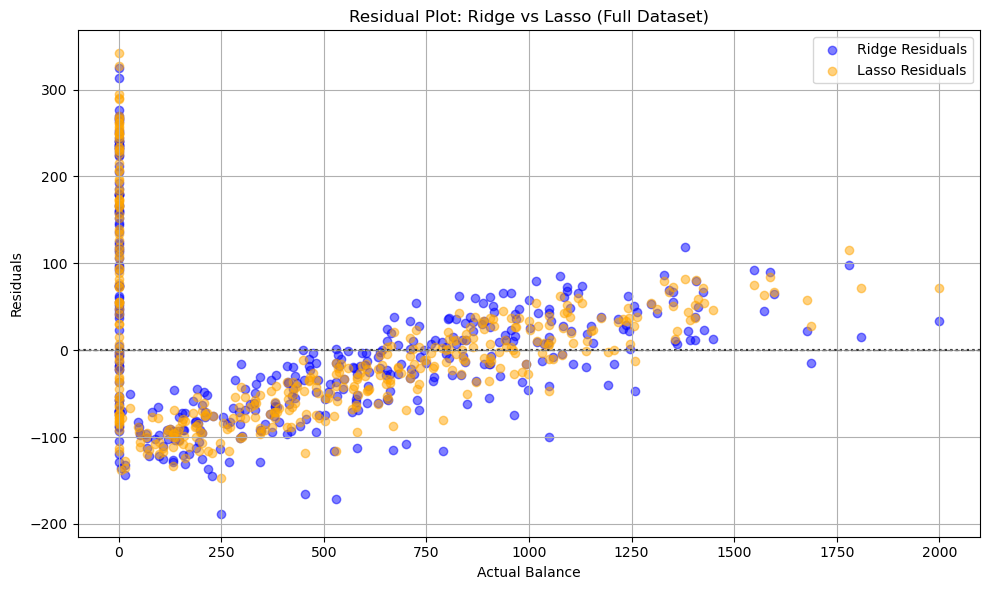

In [6]:
import seaborn as sns

ridge_residuals = y - y_pred_ridge
lasso_residuals = y - y_pred_lasso

plt.figure(figsize=(10, 6))

sns.residplot(x=y, y=ridge_residuals, color='blue', label='Ridge Residuals', scatter_kws={'alpha': 0.5})
sns.residplot(x=y, y=lasso_residuals, color='orange', label='Lasso Residuals', scatter_kws={'alpha': 0.5})


plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Actual Balance')
plt.ylabel('Residuals')
plt.title('Residual Plot: Ridge vs Lasso (Full Dataset)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Interpretation:**
- Both Ridge and Lasso residuals hover around the horizontal line 
y=0, indicating reasonably unbiased predictions.

- However, *Lasso residuals appear more evenly spread and centered*, suggesting a better fit with less systematic error.

- *Ridge shows slightly more curvature*, which may indicate potential underfitting or less flexibility.


## **Final Conclusion**

This project explored and compared **Ridge** and **Lasso Regression** models for predicting `Balance` in a financial dataset using qualitative and quantitative features.

### Key Takeaways:

- **Lasso Regression outperformed Ridge Regression** in terms of lower MSE, RMSE, and RSS.
- **Adjusted R²** for Lasso was slightly higher (0.9538) than Ridge (0.9519), indicating marginally better explanatory power.
- **Lasso performed implicit feature selection**, setting at least one coefficient to zero, simplifying the model and improving interpretability.
- **Residual analysis** revealed more stable and centered residuals for Lasso, supporting the quantitative findings.

### Overall:
If the goal is **predictive accuracy with model simplicity**, **Lasso Regression** is the better choice for this problem. However, **Ridge** can still be valuable when all predictors are important or multicollinearity is severe.


